In [2]:
import numpy as np
import pandas as pd
import torch
from PIL import Image, ExifTags
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import json

In [3]:
!nvidia-smi

Tue Jun 20 18:50:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000000:37:00.0 Off |                    0 |
| N/A   40C    P0               39W / 250W|   5334MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.is_available()

True

In [5]:
device = "cuda"

The task
Your tasks for training and deploying a simple object detector to detect litter and trash are:
1. Extract object proposals for all the images of the dataset (e.g. Selecting Search, Edge Boxes, etc). Note that you may have to resize the images before you run SS for better efficiency.
2. Finetune a convolutional neural network to classify object proposals.
3. Apply the model on the test images and implement non-maximum sup- presion and Intersection over Union (IoU).
4. Evaluate the object detection performance using standard metrics.
Optional tasks:
1. Improve the simple model above by adding a bounding-box regression output that improves the detection performance.
2. Improve the efficiency of the simple model (i.e., ROI pooling layer inspired by Fast RCNN).
3. Implement a Convolutional Neural Network that is trained to generate generic object proposals to replace the object proposal algorithm (i.e., Region Proposal Network inspired by Faster RCNN).
The goal of the project is not to simply apply an object detection model that you find online, but rather to build step-by-step a simple model by yourself. After that, feel free to improve this model by following the suggestions in the optional tasks above or to even apply a single-stage object detector.

In [6]:
%matplotlib inline

## Misc init

In [7]:
# DRIVE dataset
!( \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd dtu; \
cd datasets1; \
cd 02514; \
cd data_wastedetection; \
ls; \
)

all_image_urls.csv  batch_10  batch_13	batch_2  batch_5  batch_8
annotations.json    batch_11  batch_14	batch_3  batch_6  batch_9
batch_1		    batch_12  batch_15	batch_4  batch_7


In [8]:
DATASET_PATH = '../../../../../../../../dtu/datasets1/02514/data_wastedetection'
ANNOTATIONS_FILE_PATH = DATASET_PATH + '/' + 'annotations.json'

In [9]:
# Obtain Exif EXIF_KEY_ORIENTATION tag code
EXIF_KEY_ORIENTATION = None
for key in ExifTags.TAGS.keys():
    if ExifTags.TAGS[key] == 'Orientation':
        EXIF_KEY_ORIENTATION = key
        break
assert EXIF_KEY_ORIENTATION

In [10]:
coco_annotations = COCO(ANNOTATIONS_FILE_PATH)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [11]:
with open(ANNOTATIONS_FILE_PATH, 'r') as f:
    dataset = json.loads(f.read())

In [12]:
# create IDs for super categories
SUPER_CATEGORIES = set()
for sub_category_d in dataset["categories"]:
    superCategoryName = sub_category_d["supercategory"]
    SUPER_CATEGORIES.add(superCategoryName)
SUPER_CATEGORIES_ID_TO_NAME = {id:name for id, name in enumerate(SUPER_CATEGORIES)}
SUPER_CATEGORIES_NAME_TO_ID = {name:id for id, name in enumerate(SUPER_CATEGORIES)}

# create SUB -> SUPER dictionary
SUB_ID_TO_SUPER_ID = {}
for sub_category_d in dataset["categories"]:
    superCategoryName = sub_category_d["supercategory"]
    subCategoryId = sub_category_d["id"]
    subCategoryName = sub_category_d["name"]
    # add super category id to sub 
    SUB_ID_TO_SUPER_ID[subCategoryId] = SUPER_CATEGORIES_NAME_TO_ID[superCategoryName]


In [13]:
class _BoundingBox:
    def __init__(self, d):
        self.x,self.y,self.w,self.h = d["bbox"]
        self.xywh = d["bbox"]
        self.subCategoryId = d["category_id"]
        self.superCategoryId = SUB_ID_TO_SUPER_ID[self.subCategoryId]
        self.superCategoryName = SUPER_CATEGORIES_ID_TO_NAME[self.superCategoryId]
        self.label = superCategoryName
        self.imageId = d["image_id"]
        
        

In [14]:
class _Image:
    def __init__(self, d, coco_annotations):
        self.id = d["id"]
        self.width = d["width"]
        self.height = d["height"]
        self.path = d["file_name"]
        
        # get image - rotate if necessary
        _image = Image.open(DATASET_PATH + '/' + self.path)
        if _image._getexif():
            exif = dict(_image._getexif().items())
            if EXIF_KEY_ORIENTATION in exif:
                if exif[EXIF_KEY_ORIENTATION] == 3: _image = _image.rotate(180,expand=True)
                elif exif[EXIF_KEY_ORIENTATION] == 6: _image = _image.rotate(270,expand=True)
                elif exif[EXIF_KEY_ORIENTATION] == 8: _image = _image.rotate(90,expand=True)
        self.image = np.array(_image)
        
        # get bounding boxes 
        annotations = coco_annotations.loadAnns(coco_annotations.getAnnIds(imgIds=self.id, catIds=[], iscrowd=None))
        self.boundingBoxes = [_BoundingBox(object_d) for object_d in annotations]
    
    def imshow(self, annotations=True):
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(self.image)
        for boundingBox in self.boundingBoxes:
            x,y,w,h = boundingBox.xywh
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor="green",
                         facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)
            # add self.label to upper left corner of rect
            plt.text(x,y,f"{boundingBox.superCategoryName}", color="white", size=int(self.image.shape[1]/250))
        plt.show()
        

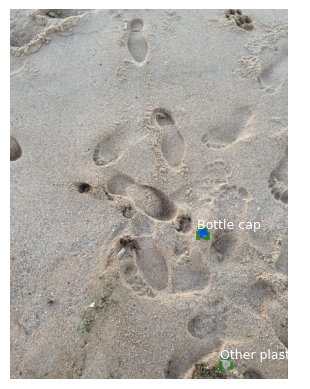

In [15]:
# create instance of _Image and plot

d_img = dataset["images"][np.random.randint(0,1000)]
image = _Image(d_img, coco_annotations)
image.imshow()

In [16]:
# custom torch dataset object
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset["images"])

    def __getitem__(self, idx):
        d = self.dataset["images"][idx]
        Image = _Image(d, coco_annotations)
        if self.transform: Image.image = self.transform(Image.image) #TODO transform bbs
        return Image

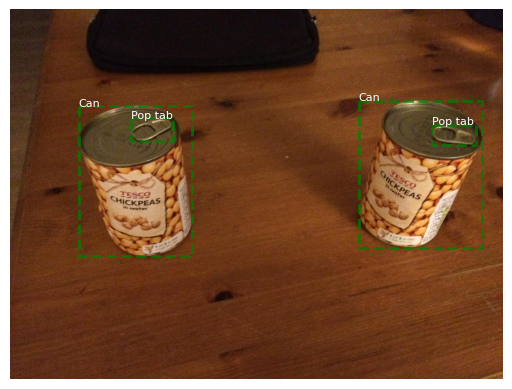

In [17]:
_dataset = Dataset(dataset)
_dataset[20].imshow()

# Selective Search

In [18]:
# ! pip install selective-search
# ! pip install albumentations
import skimage
import selective_search
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import albumentations as A
# from albumentations.augmentations.bbox_utils import convert_bbox_from_albumentations, convert_bbox_to_albumentations
from PIL import Image

Check image an get necesary data

In [19]:
d_img = dataset["images"][20]
image = _Image(d_img, coco_annotations)

im1 = image.image
bbox1 = [bbox.xywh for bbox in image.boundingBoxes]
cat = [bbox.superCategoryName for bbox in image.boundingBoxes]
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(im1)
plt.axis('off')


(-0.5, 2048.5, 1536.5, -0.5)

We need to resize the images, to expensive to do it with same image. We must resize the bounding box with same scale. 

In [ ]:
transform = A.Compose([
    A.Resize(512, 512)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))


In [ ]:
transformed = transform(image=im1, bboxes=bbox1, category_id=cat)

In [ ]:
def reshape512(image):
    """
    image:
        d_img = dataset["images"][20]
        image = _Image(d_img, coco_annotations)
    """
    im1 = image.image
    bbox1 = [bbox.xywh for bbox in image.boundingBoxes]
    cat = [bbox.superCategoryName for bbox in image.boundingBoxes]
    transform = A.Compose([
        A.Resize(512, 512)
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

    transformed = transform(image=im1, bboxes=bbox1, category_id=cat)
       
    return im1, transformed

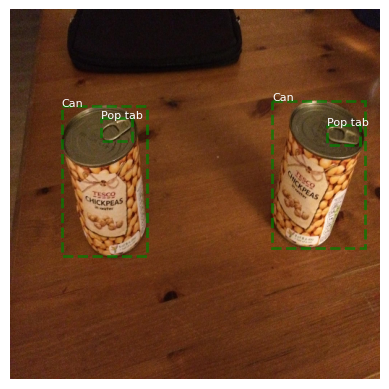

In [ ]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(transformed["image"])
for i, box in enumerate(transformed["bboxes"]):
    x,y,w,h = box
    rect = Rectangle((x,y),w,h,linewidth=2,edgecolor="green",
                facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)
        # add self.label to upper left corner of rect
    plt.text(x,y,f"{transformed['category_id'][i]}", color="white", size=int(im1.shape[1]/250))

In [ ]:
# Propose boxes using selective search
boxes = selective_search.selective_search(transformed["image"], mode='fast')

/zhome/c0/a/164613/Desktop/venv_ml/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/zhome/c0/a/164613/Desktop/venv_ml/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/zhome/c0/a/164613/Desktop/venv_ml/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function 

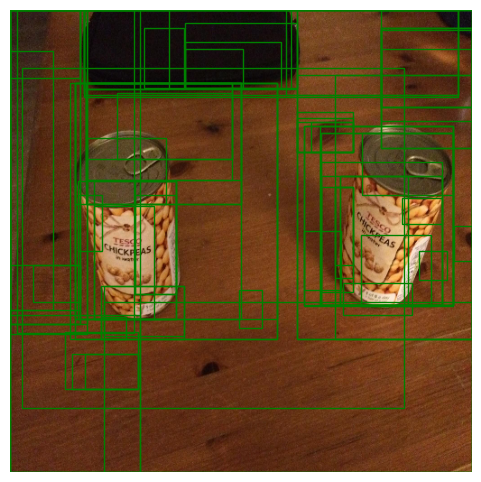

In [ ]:
boxes_filter = selective_search.box_filter(boxes, min_size=20, topN=80)
# drawing rectangles on the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(transformed["image"])
boxes = []
for x1, y1, x2, y2 in boxes_filter:
    x1, y1, width, height = x1, y1, (x2-x1), (y2-y1)
    bbox = mpatches.Rectangle(
        (x1, y1), width, height, fill=False, edgecolor='green', linewidth=1)
    ax.add_patch(bbox)
    boxes.append((x1, y1, width, height))

plt.axis('off')
plt.show()

In [ ]:
def calculate_iou(rect1, rect2):
    # Extract rectangle coordinates
    x, y, w, h = rect1
    x1, y1, w1, h1 = rect2
    
    # Calculate rectangle areas
    area_rect1 = w * h
    area_rect2 = w1 * h1
    
    # Find the coordinates of the intersection rectangle
    left = max(x, x1)
    top = max(y, y1)
    right = min(x + w, x1 + w1)
    bottom = min(y + h, y1 + h1)
    
    # Check for non-overlapping rectangles
    if left >= right or top >= bottom:
        return 0.0
    
    # Calculate the area of the intersection rectangle
    intersection_area = (right - left) * (bottom - top)
    
    # Calculate the union area
    union_area = area_rect1 + area_rect2 - intersection_area
    
    # Calculate the IoU
    iou = intersection_area / union_area
    
    return iou

In [ ]:
def calcIoU(transformed, boxes_posible):

    true_boxes = transformed["bboxes"]
    categories = transformed["category_id"]

    label_boxes = {}

    for i, val in enumerate(categories):
        label_boxes[i] = [val]
    label_boxes[i+1] = ["Background"]

    for b_p in boxes_posible:
        list_iou = []
        for b_t in true_boxes:
            iou_tmp = calculate_iou(b_t, b_p)
            list_iou.append(iou_tmp)
        # Tranform to np array 
        list_iou = np.array(list_iou)
        # Check if the box is between thresholds
        if all(list_iou > 0.3) and all(list_iou < 0.7):
            pass 
        # check background
        elif all(list_iou <= 0.3):
            label_boxes[4].append([b_p, 0])
        
        # check for the max IoU
        elif any(list_iou >= 0.7):
            max_value = np.max(list_iou)
            max_index = np.argmax(list_iou)
            label_boxes[max_index].append([b_p, max_value])

    return label_boxes

In [ ]:
d = calcIoU(transformed, boxes)

In [ ]:
# d = {0: ['Can'], 1: ['Can', [(325, 128, 165, 200), 0.7588799916045248], [(325, 128, 165, 198), 0.7529615554137049], [(343, 128, 147, 198), 0.8423831929517446], [(343, 136, 147, 190), 0.8125329330761872], [(344, 136, 146, 190), 0.8177369923528582]], 2: ['Pop tab'], 3: ['Pop tab'], 4: ['Background', (0, 0, 512, 512), (7, 0, 130, 357), (81, 0, 415, 96), (81, 0, 415, 94), (305, 0, 191, 94), (81, 0, 237, 87), (13, 64, 423, 377), (369, 302, 76, 36), (0, 0, 144, 512), (0, 338, 144, 174), (60, 356, 81, 63), (68, 381, 73, 38), (100, 305, 92, 59), (318, 112, 62, 45), (318, 119, 62, 38), (411, 0, 101, 152), (104, 323, 408, 189), (100, 340, 28, 24), (492, 239, 20, 39), (81, 0, 230, 87), (193, 14, 125, 72), (318, 124, 62, 33), (104, 305, 88, 56), (0, 0, 85, 359), (0, 0, 85, 347), (0, 0, 77, 347), (0, 282, 77, 65), (25, 282, 52, 41), (388, 249, 78, 79), (333, 124, 47, 33), (411, 19, 101, 133), (411, 19, 101, 104), (453, 267, 31, 32), (0, 0, 77, 332), (0, 0, 77, 75), (83, 381, 58, 38), (148, 19, 44, 67), (253, 310, 26, 42), (411, 19, 101, 88), (325, 244, 41, 66), (193, 35, 107, 51), (411, 22, 101, 85), (72, 80, 183, 134), (84, 80, 171, 134), (390, 136, 100, 69), (84, 80, 171, 108), (344, 196, 36, 116), (360, 196, 20, 100), (360, 196, 20, 86), (81, 0, 95, 87), (193, 43, 65, 43), (411, 43, 101, 64), (434, 208, 44, 29), (75, 204, 26, 63), (85, 141, 87, 73), (84, 80, 162, 108), (84, 80, 162, 85), (118, 92, 128, 73), (0, 45, 47, 287), (138, 189, 45, 125), (138, 204, 45, 110)]}

In [ ]:
def crop_resize(image, label_dict):
    # create a dict of croped and resized images 
    croped_images = {}

    for key in label_dict.keys():
        croped_images[key] = label_dict[key][0]
    
    # Get a max number for the background to not unbalance 
    len_dict = []
    for _, i in d.items():
        len_dict.append(len(i))
    # Omit background and tranform to np.array
    len_dict = np.array(len_dict[:-1])
    # Max number of background images 
    N = max(len_dict)

    # Define a tranformation for resizing using Albumentations
    transform = A.Compose([
        A.Resize(256, 256),
    ])

    # Iterate over all boxes to obtain the croped images 
    for key in d.keys():
        for i, item in enumerate(d[key]):
            # Check N for the backgorund
            if i < N: 
                # Avoid first element as it's the class 
                try: 
                    # Obtain the boxes dimensions
                    x, y, w, h = item[0]
                    # Crop image from box area 
                    cropped_image = image[:, y:y+height, x:x+width]
                    # Apply the resize transom to cropped image
                    resized_image = transform(image=cropped_image.numpy())
                    croped_images[key].append(resized_image)

                except ValueError:
                    pass
            else:
                pass
    return croped_images

In [ ]:
crop_resize(im1, d)

In [ ]:
# reshape to 512
# Find boxes
# Filter boxes based on IoU 
# Crop and resize Images

d_img = dataset["images"][20]
image = _Image(d_img, coco_annotations)

def crop_images(im):
    im1, transformed = reshape512(im)
    # Propose boxes using selective search
    boxes = selective_search.selective_search(transformed["image"], mode='fast')
    d = calcIoU(transformed, boxes)
    crop_resize_images = crop_resize(im1, d)
    return crop_resize_images


Then here we should have a for loop for all the dataset and store the rest in a ist or dict